# Mini-Lab: Logistic Regression and SVMs

Names:
Dylan Scott
Jobin Joseph
Nnenna Okpara
Satvik Ajmera

Instructions:
You are to perform predictive analysis (classification) upon a data set: model the dataset using
methods we have discussed in class: logistic regression and support vector machines, and making
conclusions from the analysis. Follow the CRISP-DM framework in your analysis (you are not
performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined
below). This report is worth 10% of the final grade. You may complete this assignment in teams of
as many as three people.

Write a report covering all the steps of the project. The format of the document can be PDF,
*.ipynb, or HTML. You can write the report in whatever format you like, but it is easiest to turn in the
rendered iPython notebook. The results should be reproducible using your report. Please carefully
describe every assumption and every step in your report.

SVM and Logistic Regression Modeling
• [50 points] Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset. Assess how well each model performs (use
80/20 training/testing split for your data). Adjust parameters of the models to make them more
accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel
only is fine to use.

[pick performance stats]

• [10 points] Discuss the advantages of each model for each classification task. Does one type
of model offer superior performance over another in terms of prediction accuracy? In terms of
training time or efficiency? Explain in detail.

• [30 points] Use the weights from logistic regression to interpret the importance of different
features for each classification task. Explain your interpretation in detail. Why do you think
some variables are more important?

• [10 points] Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

import plotly.express as px
import plotly.graph_objects as go

### Dataset add-on
From the first project we submitted we have since added on more data that we found on the NTSB website. We were able to merge in new columns using join as well as apend on more recent data. This will give us more vairables but we will have to clean up some of those added rows. This next section will be the clean up.

In [2]:
#Read in the Aviation Data
final_data = pd.read_csv("Data/final_data.csv",low_memory=False,dtype={'damage': str})
#Delete columns that were imported incorrectly
del final_data["Unnamed: 0"]
del final_data["dprt_state.1"]
del final_data["index"]
del final_data["ntsb_no_x"]
del final_data['ev_id']

final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115706 entries, 0 to 115705
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   acft_make          115643 non-null  object 
 1   acft_model         115630 non-null  object 
 2   cert_max_gr_wt     98673 non-null   float64
 3   acft_category      115287 non-null  object 
 4   damage             113877 non-null  object 
 5   far_part           114925 non-null  object 
 6   afm_hrs_last_insp  60298 non-null   float64
 7   type_fly           108599 non-null  object 
 8   dprt_city          111864 non-null  object 
 9   dprt_state         108791 non-null  object 
 10  rwy_len            64222 non-null   float64
 11  rwy_width          63110 non-null   float64
 12  ev_type            115706 non-null  object 
 13  ev_city            115646 non-null  object 
 14  ev_state           109635 non-null  object 
 15  ev_country         115199 non-null  object 
 16  ev

# Data Cleaning Overview

We fixed the levels of columns that should have been grouped together for the `damage` predictor. We fixed the levels of the `ev_city`, by making all the city names uppercase so they would be grouped together. For `wind_vel_ind` the unknown values were labeled as `U` and `UNK` to `UNK`. Then, we took the subset of the continuous predictors: `cert_max_gr_wt`,`afm_hrs_last_insp`,`rwy_len`, and `rwy_width` and removed all the NAs. We were left with approximately 35,000 rows that would be usable for prediction.

The NTSB database allowed use to include ground injuries in addition to flight injuries. So we renamed the columns, replaced the NAs in these columns with 0 and summed all them to get a total injuries column. We wanted to only include the total injuries and drop the other types of injury columns. From there, we converted the total injuries column to a binary variable for classification. If the total injuries were greater than 1, it is considered injured and less than 1 is uninjured. Our last step was to impute all the NA's for the categorical values with an unknown value called `UNK` In all, we are left with the dataframe `final_df` which consisted of 21 columns and 35,427 observations. 

Of the 35,427 observations, 18750 observations were reported as injured and 16677 were reported as uninjured. This column called `Injury` is the response variable, we would like to predict for the classification problem.

In [3]:
finaldamagecount = final_data["damage"].value_counts().reset_index()
#Uppers won't combine
final_data['ev_city'] = final_data['ev_city'].str.upper()
ev_city_fix = final_data["ev_city"].value_counts().reset_index()

final_data.loc[final_data['damage'].str.contains('UNK', na=False), 'damage'] = 'UNK'
finaldamagecount = final_data["damage"].value_counts().reset_index()

#checking to see if wind_vel_ind had a miss-match with U and UNK
wind_count = final_data["wind_vel_ind"].value_counts().reset_index()



In [4]:
#dealing with unknnowns
#some columns we can't simply replace the blank value with "Unknown" or 0s since that will skew our data
#'cert_max_gr_wt','afm_hrs_last_insp','rwy_len','rwy_width'
# with the columns listed above we have elected to remove any rows where they are blank. This will help focus our data and it will still leave us with an ample amount of data
final_data.dropna(subset=['cert_max_gr_wt','afm_hrs_last_insp','rwy_len','rwy_width'],inplace=True)

In [5]:
#rename the injuries columns to make them easier to read
final_data = final_data.rename(columns={"inj_tot_f": "Total_Fatal_Injuries", "inj_tot_s": "Total_Serious_Injuries","inj_tot_m":"Total_Minor_Injuries","inj_tot_n":'Total_Uninjured',"inj_tot_t":"Total_Injuries_Flight"})

#fill in 0s when there wasn't an injury in that category
final_data.update(final_data[['Total_Fatal_Injuries','Total_Serious_Injuries','Total_Minor_Injuries','Total_Uninjured','Total_Injuries_Flight','inj_f_grnd','inj_m_grnd','inj_s_grnd']].fillna(0))
final_data.head()

,acft_make,acft_model,cert_max_gr_wt,acft_category,damage,far_part,afm_hrs_last_insp,type_fly,dprt_city,dprt_state,...,Total_Fatal_Injuries,Total_Minor_Injuries,Total_Uninjured,Total_Serious_Injuries,Total_Injuries_Flight,sky_cond_ceil,sky_cond_nonceil,wind_vel_ind,wx_int_precip,phase_flt_spec
1,Boeing,747-100,750000.0,AIR,MINR,121,113.0,UNK,CHITOSE,JA,...,0.0,0.0,4.0,0.0,0.0,NONE,SCAT,CALM,UNK,Landing
3,Cessna,172,2300.0,AIR,SUBS,091,40.0,PERS,,,...,0.0,0.0,1.0,0.0,0.0,BKN,UNK,UNK,LGT,Unknown
4,Cessna,207,3800.0,AIR,SUBS,135,49.0,UNK,,AK,...,0.0,0.0,1.0,0.0,0.0,BKN,UNK,UNK,UNK,Descent
6,Beech,300,14100.0,AIR,DEST,091,3.0,EXEC,GREENEVILLE,SC,...,2.0,0.0,0.0,0.0,2.0,BKN,UNK,UNK,MOD,Approach
8,Aero Commander,560A,6000.0,AIR,DEST,091,13.0,PERS,,,...,2.0,0.0,0.0,2.0,4.0,NONE,CLER,UNK,UNK,Approach


In [6]:
#set missing variables to Unknown in order to run our models
final_data.update(final_data.fillna("UNK"))

In [7]:
#we want to account for ALL injuries. This includes injuries on the ground as well as passangers
#Here we will make a new column that shows total injuries including ground ones
final_data['Total_Injuries_Ground'] = final_data['inj_f_grnd']+final_data['inj_m_grnd']+final_data['inj_s_grnd']
final_data['Total_Injuries'] = final_data['Total_Injuries_Ground']+final_data['Total_Injuries_Flight']
final_data.head()

,acft_make,acft_model,cert_max_gr_wt,acft_category,damage,far_part,afm_hrs_last_insp,type_fly,dprt_city,dprt_state,...,Total_Uninjured,Total_Serious_Injuries,Total_Injuries_Flight,sky_cond_ceil,sky_cond_nonceil,wind_vel_ind,wx_int_precip,phase_flt_spec,Total_Injuries_Ground,Total_Injuries
1,Boeing,747-100,750000.0,AIR,MINR,121,113.0,UNK,CHITOSE,JA,...,4.0,0.0,0.0,NONE,SCAT,CALM,UNK,Landing,0.0,0.0
3,Cessna,172,2300.0,AIR,SUBS,091,40.0,PERS,,,...,1.0,0.0,0.0,BKN,UNK,UNK,LGT,Unknown,0.0,0.0
4,Cessna,207,3800.0,AIR,SUBS,135,49.0,UNK,,AK,...,1.0,0.0,0.0,BKN,UNK,UNK,UNK,Descent,0.0,0.0
6,Beech,300,14100.0,AIR,DEST,091,3.0,EXEC,GREENEVILLE,SC,...,0.0,0.0,2.0,BKN,UNK,UNK,MOD,Approach,0.0,2.0
8,Aero Commander,560A,6000.0,AIR,DEST,091,13.0,PERS,,,...,0.0,2.0,4.0,NONE,CLER,UNK,UNK,Approach,0.0,4.0


In [8]:
#create a new column of injuried or not to get a binary response
#1 means someone was hurt 0 means someone was not
final_data['Injury'] = np.where(final_data['Total_Injuries'] >0,1,0)
injuries = final_data["Injury"].value_counts().reset_index()
injuries.head(3)

,index,Injury
0,1,18750
1,0,16677


<AxesSubplot:xlabel='Injury', ylabel='count'>

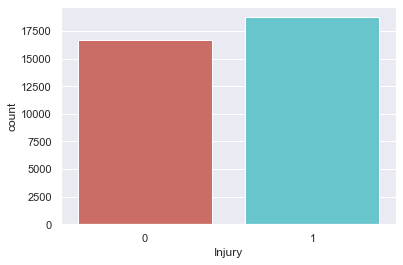

In [9]:
final_data['Injury'].value_counts()

sns.countplot(x='Injury',data=final_data,palette='hls')

In [10]:
#delete the index column called "Unnamed: 0"
final_df = final_data.copy()
#Since we added up all of our injuries we don't need the other columns that include injury count since it will be colinear to our prediction variable
final_df = final_df.drop(['Total_Fatal_Injuries','Total_Serious_Injuries','Total_Minor_Injuries','Total_Uninjured','Total_Injuries_Flight','inj_f_grnd','inj_m_grnd','inj_s_grnd','Total_Injuries_Ground',"Total_Injuries", "dprt_city"],axis = 1)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35427 entries, 1 to 115696
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   acft_make          35427 non-null  object 
 1   acft_model         35427 non-null  object 
 2   cert_max_gr_wt     35427 non-null  float64
 3   acft_category      35427 non-null  object 
 4   damage             35427 non-null  object 
 5   far_part           35427 non-null  object 
 6   afm_hrs_last_insp  35427 non-null  float64
 7   type_fly           35427 non-null  object 
 8   dprt_state         35427 non-null  object 
 9   rwy_len            35427 non-null  float64
 10  rwy_width          35427 non-null  float64
 11  ev_type            35427 non-null  object 
 12  ev_city            35427 non-null  object 
 13  ev_state           35427 non-null  object 
 14  ev_country         35427 non-null  object 
 15  ev_highest_injury  35427 non-null  object 
 16  sky_cond_ceil      35

# One Hot Encoding

Using the `final_df`, we created a variable `X` for all predictors and `y` for the response variable: `Injury`.

In [11]:
#drop prediction variable
X = final_df.drop("Injury", axis = 1).copy()
y = final_df["Injury"].copy()

### One hot encoding and tranforming our `X` and `y`:
We wanted to first one hot encode `X` and tranform it into a sparse matrix. Using the Label Encoder from sklearn we `y` into a binary array. 

In [12]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop="first")
encoder.fit(X)
X = encoder.transform(X).toarray()


In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

### Training and Testing Split
For training and testing, we gathered 80% of data for the training and 20% for testing data using `scikit-learn`. So far, we have not used cross validation.

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Creating a Logistic Regression Model using the Raw Data

In [15]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(class_weight="balanced",solver='liblinear')
logisticRegr.fit(X_train, y_train)
y_hat = logisticRegr.predict(X_test)

from sklearn import metrics as mt
accuracy_raw = mt.accuracy_score(y_test,y_hat)
conf_raw = mt.confusion_matrix(y_test,y_hat)
print("The accuracy for the raw data is: ",accuracy_raw)
print("Raw Data Confusion Matrix:")
print(conf_raw)

The accuracy for the raw data is:  0.999435506632797
Raw Data Confusion Matrix:
[[3331    4]
 [   0 3751]]


In [22]:
coefficients = pd.concat([pd.DataFrame(final_df.columns),pd.DataFrame(np.transpose(logisticRegr.coef_))], axis = 1)
coefficients.head(20)

,0,0
0,acft_make,0.000000
1,acft_model,0.000322
2,cert_max_gr_wt,0.000598
3,acft_category,0.001376
4,damage,-0.000203
5,far_part,0.000000
6,afm_hrs_last_insp,-0.004734
7,type_fly,0.002353
8,dprt_state,-0.000539
9,rwy_len,0.000806


In [23]:
# from sklearn.preprocessing import StandardScaler
# #This section normalized features
# # scale attributes by the training set
# scl_obj = StandardScaler()
# scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# # the line of code above only looks at training data to get mean and std and we can use it 
# # to transform new feature data

# # apply to training
# X_train_scaled = scl_obj.transform(X_train)
# # apply those means and std to the test set
# X_test_scaled = scl_obj.transform(X_test)  

# # Train model
# lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') 
# lr_clf.fit(X_train_scaled,y_train) 

# #Make predictions
# y_hat = lr_clf.predict(X_test_scaled)

# #Get Accuracy and generate CM
# acc = mt.accuracy_score(y_test,y_hat)
# conf = mt.confusion_matrix(y_test,y_hat)
# print('accuracy:', acc )
# print(conf )

# # sort these attributes
# zip_vars = zip(lr_clf.coef_.T,dfScaled.columns) # combine attributes
# zip_vars = sorted(zip_vars)
# for coef, name in zip_vars:
#     print(name, 'has weight of', coef[0]) # now print them out

### Standardizing and scaling the data:
From sklearn.preprocessing, the StandardScaler allowed us standardize our data. We wanted to compare performance metrics between the raw data vs. scaled and standardized data.

In [24]:
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler(with_mean=False)
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train) 
X_test_scaled = scl_obj.transform(X_test)

### Creating a Logistic Regression Model using the Standardized and Scaled Data

In [25]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(class_weight="balanced",solver='liblinear')
logisticRegr.fit(X_train_scaled, y_train)
y_hat = logisticRegr.predict(X_test_scaled)

from sklearn import metrics as mt
accuracy_stan = mt.accuracy_score(y_test,y_hat)
conf_stan = mt.confusion_matrix(y_test,y_hat)
print("The accuracy for the standardized and scaled data is:", accuracy_stan)
print("Standardized and Scaled Data Confusion Matrix:")
print(conf_stan)

C:\Users\drsco\anaconda3\envs\MachineL1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy for the standardized and scaled data is: 0.9983065198983911
Standardized and Scaled Data Confusion Matrix:
[[3334    1]
 [  11 3740]]


As we can see, the accuracy is too high. `ev_highest_injury` is a categorical level that indicates the highest level of injury among all injuries sustained as a result of the event. We found that `ev_highest_injury` must be highly correlated our response variable, `Injury`. By removing `ev_highest_injury`, our accuracy would measure better moving forward.

# Final Models

Moving forward, we will have `ev_highest_injury` removed from the final dataframe for all our models.

In [ ]:
df = final_df.copy()
del df['ev_highest_injury']

X = df.drop("Injury", axis = 1).copy()
y = df["Injury"].copy()

#one hot encoding with proper model
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop="first")
encoder.fit(X)
X = encoder.transform(X)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [ ]:
#CV split
from sklearn.model_selection import StratifiedShuffleSplit 
cv = StratifiedShuffleSplit( n_splits=5,test_size=0.2,random_state = 42)

In [ ]:
from sklearn.svm import SVC

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

CV Logistic regression with scaled 
CV SVM scaled
both graident - dylan file
KDP plots
weights for each model with explain